# XGBOOST


In [46]:
!pip install catboost

In [47]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_curve
from catboost import CatBoostClassifier  # Thay bằng CatBoost
from lightgbm import LGBMClassifier  # Thay bằng LightGBM
from xgboost import XGBClassifier
import joblib
import numpy as np
from sklearn.model_selection import train_test_split

In [48]:
import pandas as pd

# Ví dụ: nếu bạn upload thẳng file vào MyDrive
path = '/content/drive/MyDrive/PhiUSIIL_Phishing_URL_Dataset.csv'

df = pd.read_csv(path)
df.head()

,FILENAME,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
0,521848.txt,https://www.southbankmosaics.com,31,www.southbankmosaics.com,24,0,com,100.0,1.000000,0.522907,...,0,0,1,34,20,28,119,0,124,1
1,31372.txt,https://www.uni-mainz.de,23,www.uni-mainz.de,16,0,de,100.0,0.666667,0.032650,...,0,0,1,50,9,8,39,0,217,1
2,597387.txt,https://www.voicefmradio.co.uk,29,www.voicefmradio.co.uk,22,0,uk,100.0,0.866667,0.028555,...,0,0,1,10,2,7,42,2,5,1
3,554095.txt,https://www.sfnmjournal.com,26,www.sfnmjournal.com,19,0,com,100.0,1.000000,0.522907,...,1,1,1,3,27,15,22,1,31,1
4,151578.txt,https://www.rewildingargentina.org,33,www.rewildingargentina.org,26,0,org,100.0,1.000000,0.079963,...,1,0,1,244,15,34,72,1,85,1


In [49]:
X = df.drop(columns=['label'])
y = df['label']
print("Thông tin dataset: Số mẫu =", X.shape[0], "Số đặc trưng =", X.shape[1])

Thông tin dataset: Số mẫu = 235795 Số đặc trưng = 55


In [50]:
# Kiểm tra trùng lặp
duplicates = X.duplicated(keep=False).sum()
print(f"Số mẫu trùng lặp trong dataset: {duplicates}")
X = X.drop_duplicates()
y = y.loc[X.index]

Số mẫu trùng lặp trong dataset: 0


In [51]:
# Kiểm tra giá trị thiếu
print("\nSố giá trị thiếu trong mỗi cột:\n", X.isna().sum())


Số giá trị thiếu trong mỗi cột:
 FILENAME                      0
URL                           0
URLLength                     0
Domain                        0
DomainLength                  0
IsDomainIP                    0
TLD                           0
URLSimilarityIndex            0
CharContinuationRate          0
TLDLegitimateProb             0
URLCharProb                   0
TLDLength                     0
NoOfSubDomain                 0
HasObfuscation                0
NoOfObfuscatedChar            0
ObfuscationRatio              0
NoOfLettersInURL              0
LetterRatioInURL              0
NoOfDegitsInURL               0
DegitRatioInURL               0
NoOfEqualsInURL               0
NoOfQMarkInURL                0
NoOfAmpersandInURL            0
NoOfOtherSpecialCharsInURL    0
SpacialCharRatioInURL         0
IsHTTPS                       0
LineOfCode                    0
LargestLineLength             0
HasTitle                      0
Title                         0
Domain

In [52]:
# Xử lý giá trị thiếu
object_cols = X.select_dtypes(include=['object']).columns
for col in object_cols:
    X[col] = X[col].fillna(X[col].mode()[0])
X = X.fillna(X.select_dtypes(include=['float', 'int']).median())

In [53]:
# Kiểm tra cardinality
for col in object_cols:
    print(f"Cột {col}: {X[col].nunique()} giá trị duy nhất")

Cột FILENAME: 235795 giá trị duy nhất
Cột URL: 235370 giá trị duy nhất
Cột Domain: 220086 giá trị duy nhất
Cột TLD: 695 giá trị duy nhất
Cột Title: 197874 giá trị duy nhất


In [54]:
# Loại bỏ cột high cardinality
high_cardinality_cols = ['FILENAME', 'URL', 'Domain', 'TLD', 'Title']
X = X.drop(columns=high_cardinality_cols, errors='ignore')

In [55]:
# Xử lý cột boolean (chuyển thành 0/1 trực tiếp)
boolean_cols = ['IsDomainIP', 'HasObfuscation', 'IsHTTPS', 'HasTitle', 'HasFavicon',
                'Robots', 'IsResponsive', 'HasDescription', 'HasExternalFormSubmit',
                'HasSocialNet', 'HasSubmitButton', 'HasHiddenFields', 'HasPasswordField',
                'Bank', 'Pay', 'Crypto', 'HasCopyrightInfo']
for col in boolean_cols:
    if col in X.columns:
        X[col] = X[col].astype(int)  # Giả sử dữ liệu đã là 0/1 hoặc True/False

In [56]:
# Chia dữ liệu thành train/val/test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.667, random_state=42)
print(f"Kích thước tập train: {X_train.shape}")
print(f"Kích thước tập validation: {X_val.shape}")
print(f"Kích thước tập test: {X_test.shape}")

Kích thước tập train: (165056, 50)
Kích thước tập validation: (23556, 50)
Kích thước tập test: (47183, 50)


In [57]:
# Kiểm tra tương quan với nhãn
correlations = X_train.corrwith(y_train)
print("\nTương quan với nhãn:\n", correlations.sort_values(ascending=False))


Tương quan với nhãn:
 URLSimilarityIndex            0.860129
HasSocialNet                  0.784279
HasCopyrightInfo              0.743825
HasDescription                0.691362
IsHTTPS                       0.609225
DomainTitleMatchScore         0.584144
HasSubmitButton               0.578794
IsResponsive                  0.548107
URLTitleMatchScore            0.538722
HasHiddenFields               0.508374
HasFavicon                    0.496879
URLCharProb                   0.468342
CharContinuationRate          0.467093
HasTitle                      0.459084
Robots                        0.391704
Pay                           0.361259
NoOfJS                        0.341882
NoOfSelfRef                   0.303228
LineOfCode                    0.295884
NoOfImage                     0.270416
NoOfExternalRef               0.248561
NoOfiFrame                    0.212890
Bank                          0.189387
HasExternalFormSubmit         0.167270
HasPasswordField              0.139424
No

In [58]:
# Loại bỏ đặc trưng có tương quan cao (>0.8 để chặt chẽ hơn)
suspicious_features = correlations[abs(correlations) > 0.8].index.tolist()
if suspicious_features:
    print(f"Loại bỏ các đặc trưng nghi ngờ: {suspicious_features}")
    X_train = X_train.drop(columns=suspicious_features)
    X_val = X_val.drop(columns=suspicious_features)
    X_test = X_test.drop(columns=suspicious_features)

Loại bỏ các đặc trưng nghi ngờ: ['URLSimilarityIndex']


In [59]:
# Xem mẫu dữ liệu để kiểm tra label leakage
print("\nMẫu dữ liệu (10 mẫu đầu):\n", X.head(10))
print("\nNhãn tương ứng:\n", y.head(10))


Mẫu dữ liệu (10 mẫu đầu):
    URLLength  DomainLength  IsDomainIP  URLSimilarityIndex  \
0         31            24           0               100.0   
1         23            16           0               100.0   
2         29            22           0               100.0   
3         26            19           0               100.0   
4         33            26           0               100.0   
5         30            23           0               100.0   
6         25            18           0               100.0   
7         25            18           0               100.0   
8         29            22           0               100.0   
9         18            11           0               100.0   

   CharContinuationRate  TLDLegitimateProb  URLCharProb  TLDLength  \
0              1.000000           0.522907     0.061933          3   
1              0.666667           0.032650     0.050207          2   
2              0.866667           0.028555     0.064129          2   
3        

In [60]:
# Tính trọng số lớp
class_weights = len(y) / (2 * y.value_counts())
weight_dict = {0: class_weights[0], 1: class_weights[1]}

In [61]:
# Tinh chỉnh mô hình XGBoost
model = XGBClassifier(
    random_state=42,
    scale_pos_weight=weight_dict[1]/weight_dict[0],
    reg_alpha=5.0,  # Tăng L1 regularization
    reg_lambda=6.0,  # Tăng L2 regularization
    max_depth=2,    # Giảm độ sâu
    n_estimators=20, # Giảm số cây
    subsample=0.6,  # Giảm tỷ lệ mẫu
    colsample_bytree=0.6, # Giảm tỷ lệ đặc trưng
    min_child_weight=15 # Tăng trọng số tối thiểu
)
param_grid = {
    'n_estimators': [20],
    'max_depth': [2],
    'learning_rate': [0.01, 0.05],
    'min_child_weight': [15, 20]
}
grid_search = GridSearchCV(model, param_grid, cv=10, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.6, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=2,
                                     max_leaves=None, min_child_weight=15,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=20,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05], 'max_depth': [2],
                         'min_child_weight': [15, 20], 'n_estimators': [20]},
             scoring='f1')

In [62]:
# Lấy mô hình tốt nhất
best_model = grid_search.best_estimator_
print("Tham số tốt nhất:", grid_search.best_params_)
print("Điểm F1 trung bình trên 10-fold CV:", grid_search.best_score_)

Tham số tốt nhất: {'learning_rate': 0.05, 'max_depth': 2, 'min_child_weight': 15, 'n_estimators': 20}
Điểm F1 trung bình trên 10-fold CV: 0.9902710090340399


In [63]:
# Tìm ngưỡng tối ưu
y_val_pred_proba = best_model.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_val_pred_proba)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Ngưỡng tối ưu: {optimal_threshold}")

Ngưỡng tối ưu: 0.4382323622703552


In [64]:
# Kiểm tra tầm quan trọng đặc trưng
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)
print("\nTầm quan trọng đặc trưng:\n", feature_importance.head(10))


Tầm quan trọng đặc trưng:
                        feature  importance
48             NoOfExternalRef    0.474682
21                  LineOfCode    0.219147
46                 NoOfSelfRef    0.115576
35                HasSocialNet    0.029688
13             NoOfDegitsInURL    0.023970
0                    URLLength    0.023970
18  NoOfOtherSpecialCharsInURL    0.019101
43                   NoOfImage    0.017992
42            HasCopyrightInfo    0.016842
31              HasDescription    0.016063


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [68]:
# Đánh giá trên tập train
y_pred_train = best_model.predict(X_train)
print("\nBáo cáo phân loại trên tập train:")
print(classification_report(y_train, y_pred_train))


Báo cáo phân loại trên tập train:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     70794
           1       0.99      0.99      0.99     94262

    accuracy                           0.99    165056
   macro avg       0.99      0.99      0.99    165056
weighted avg       0.99      0.99      0.99    165056



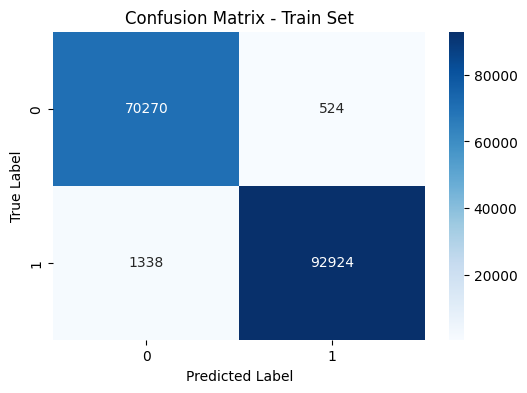

In [73]:
cm = confusion_matrix(y_train, y_pred_train)
labels = [0, 1]  # 0: Benign, 1: Phishing

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix - Train Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [75]:
# Đánh giá trên tập validation
y_pred_val = best_model.predict(X_val)
print("\nBáo cáo phân loại trên tập validation:")
print(classification_report(y_val, y_pred_val))


Báo cáo phân loại trên tập validation:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     10037
           1       0.99      0.98      0.99     13519

    accuracy                           0.99     23556
   macro avg       0.99      0.99      0.99     23556
weighted avg       0.99      0.99      0.99     23556



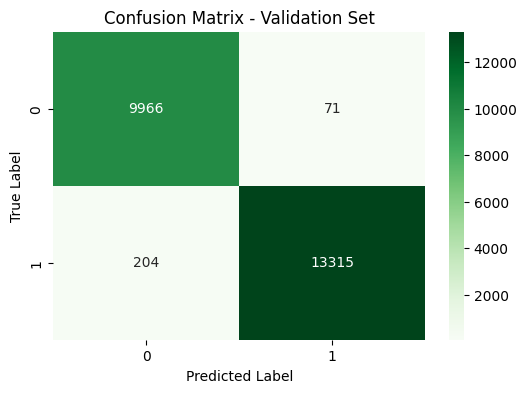

In [76]:
# Vẽ confusion matrix cho validation
cm_val = confusion_matrix(y_val, y_pred_val)
labels = [0, 1]  # 0: An toàn, 1: Phishing

plt.figure(figsize=(6, 4))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Greens',
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix - Validation Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [77]:
# Đánh giá trên tập test
y_pred_test = best_model.predict(X_test)
print("\nBáo cáo phân loại trên tập test:")
print(classification_report(y_test, y_pred_test))


Báo cáo phân loại trên tập test:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     20114
           1       0.99      0.99      0.99     27069

    accuracy                           0.99     47183
   macro avg       0.99      0.99      0.99     47183
weighted avg       0.99      0.99      0.99     47183



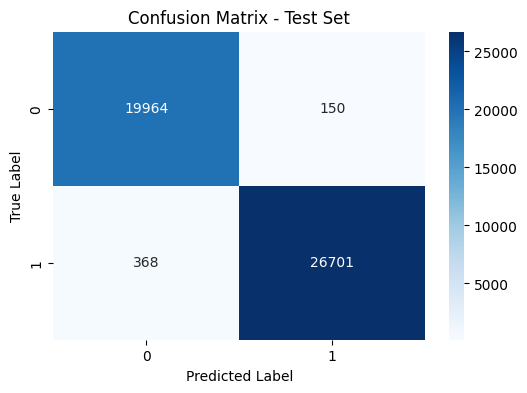

In [78]:
# Tạo confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
labels = [0, 1]  # 0: An toàn, 1: Phishing

# Vẽ heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

**Kiểm tra Overfitting/Underfitting**

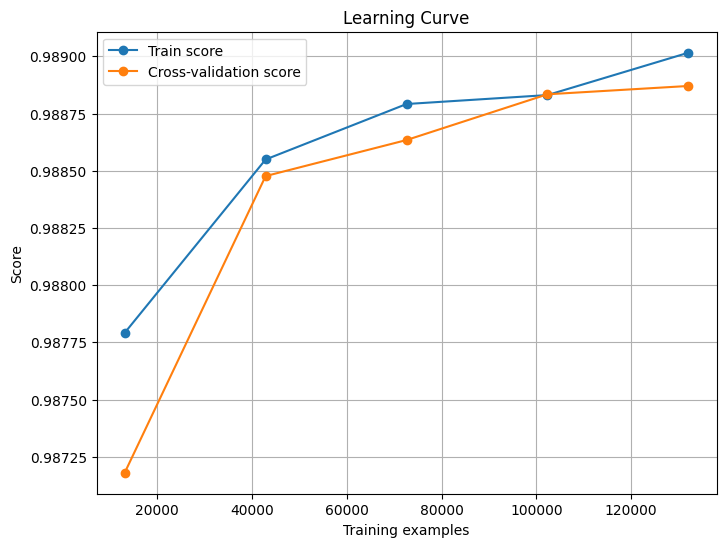

In [79]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train, y_train, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1
)

train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', label='Train score')
plt.plot(train_sizes, test_scores_mean, 'o-', label='Cross-validation score')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()


**Đánh giá hiệu năng tổng thể**

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
y_score = best_model.predict_proba(X_test)[:, 1]

# Tính FPR (False Positive Rate) và TPR (True Positive Rate)
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# Vẽ biểu đồ ROC
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Đường tham chiếu
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Test Set')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

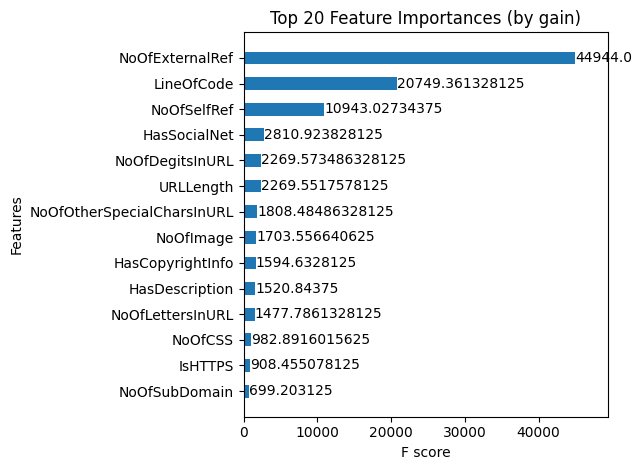

In [72]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Sử dụng trực tiếp mô hình
xgb_model = best_model

# Vẽ biểu đồ độ quan trọng đặc trưng
xgb.plot_importance(xgb_model,
                    importance_type='gain',  # Có thể thay bằng 'weight', 'cover', ...
                    max_num_features=20,
                    height=0.5,
                    grid=False,
                    title="Top 20 Feature Importances (by gain)")
plt.tight_layout()
plt.show()


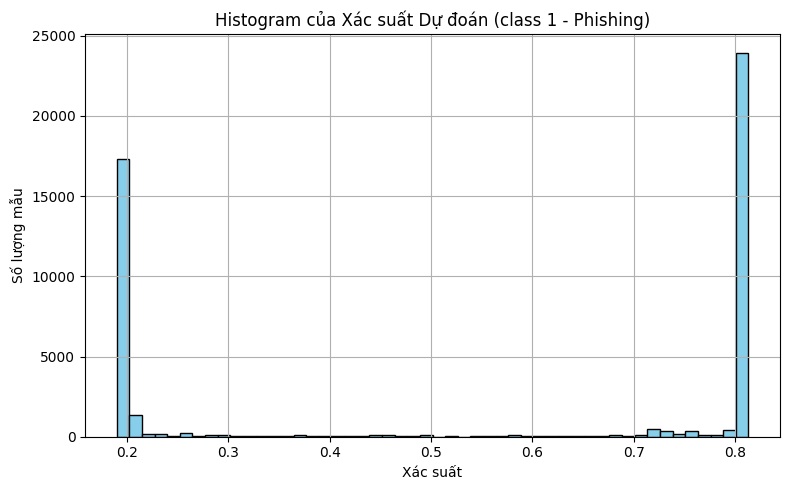

In [83]:
import matplotlib.pyplot as plt

# Dự đoán xác suất class 1 (phishing) trên tập test
y_proba = best_model.predict_proba(X_test)[:, 1]

# Vẽ histogram
plt.figure(figsize=(8, 5))
plt.hist(y_proba, bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram của Xác suất Dự đoán (class 1 - Phishing)')
plt.xlabel('Xác suất')
plt.ylabel('Số lượng mẫu')
plt.grid(True)
plt.tight_layout()
plt.show()


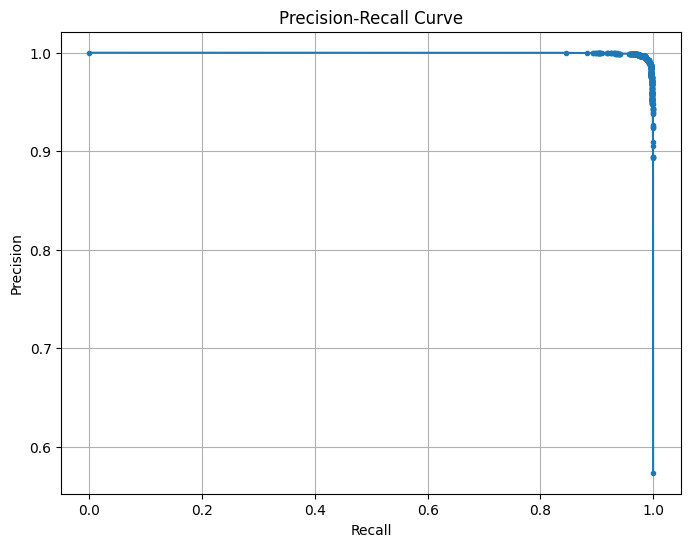

In [85]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()


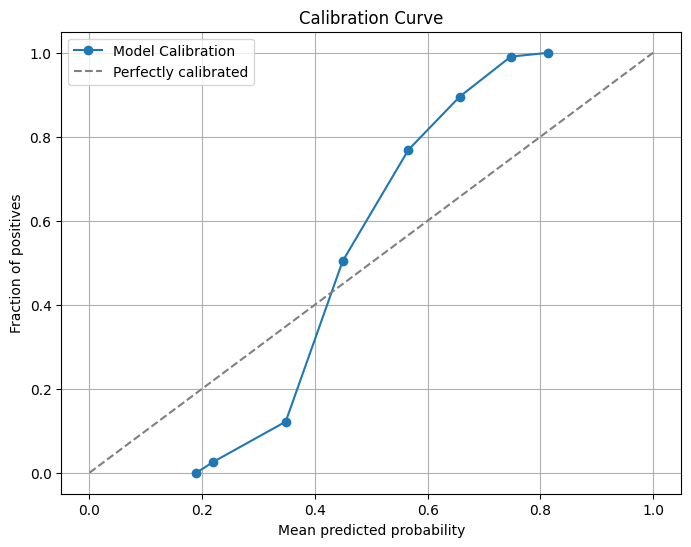

In [84]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Model Calibration')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curve')
plt.legend()
plt.grid(True)
plt.show()


In [86]:
!pip install shap


 94%|=================== | 44501/47183 [00:17<00:01]       

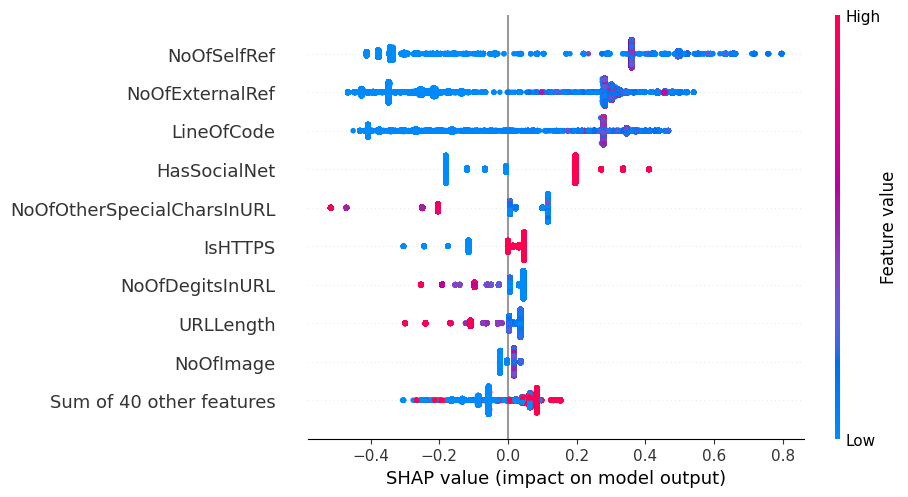

In [87]:
import shap

# Tạo đối tượng explainer cho XGBoost
explainer = shap.Explainer(best_model, X_train)

# Tính toán giá trị SHAP cho tập validation hoặc test
shap_values = explainer(X_test)

# Vẽ biểu đồ tổng quan
shap.plots.beeswarm(shap_values)


# LightGBM

In [107]:
import pandas as pd

# Ví dụ: nếu bạn upload thẳng file vào MyDrive
path = '/content/drive/MyDrive/PhiUSIIL_Phishing_URL_Dataset.csv'

df = pd.read_csv(path)
df.head()

,FILENAME,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
0,521848.txt,https://www.southbankmosaics.com,31,www.southbankmosaics.com,24,0,com,100.0,1.000000,0.522907,...,0,0,1,34,20,28,119,0,124,1
1,31372.txt,https://www.uni-mainz.de,23,www.uni-mainz.de,16,0,de,100.0,0.666667,0.032650,...,0,0,1,50,9,8,39,0,217,1
2,597387.txt,https://www.voicefmradio.co.uk,29,www.voicefmradio.co.uk,22,0,uk,100.0,0.866667,0.028555,...,0,0,1,10,2,7,42,2,5,1
3,554095.txt,https://www.sfnmjournal.com,26,www.sfnmjournal.com,19,0,com,100.0,1.000000,0.522907,...,1,1,1,3,27,15,22,1,31,1
4,151578.txt,https://www.rewildingargentina.org,33,www.rewildingargentina.org,26,0,org,100.0,1.000000,0.079963,...,1,0,1,244,15,34,72,1,85,1


In [108]:
# Kiểm tra trùng lặp
duplicates = X.duplicated(keep=False).sum()
print(f"Số mẫu trùng lặp trong dataset: {duplicates}")
X = X.drop_duplicates()
y = y.loc[X.index]


Số mẫu trùng lặp trong dataset: 0


In [109]:
# Kiểm tra giá trị thiếu
print("\nSố giá trị thiếu trong mỗi cột:\n", X.isna().sum())


Số giá trị thiếu trong mỗi cột:
 URLLength                     0
DomainLength                  0
IsDomainIP                    0
URLSimilarityIndex            0
CharContinuationRate          0
TLDLegitimateProb             0
URLCharProb                   0
TLDLength                     0
NoOfSubDomain                 0
HasObfuscation                0
NoOfObfuscatedChar            0
ObfuscationRatio              0
NoOfLettersInURL              0
LetterRatioInURL              0
NoOfDegitsInURL               0
DegitRatioInURL               0
NoOfEqualsInURL               0
NoOfQMarkInURL                0
NoOfAmpersandInURL            0
NoOfOtherSpecialCharsInURL    0
SpacialCharRatioInURL         0
IsHTTPS                       0
LineOfCode                    0
LargestLineLength             0
HasTitle                      0
DomainTitleMatchScore         0
URLTitleMatchScore            0
HasFavicon                    0
Robots                        0
IsResponsive                  0
NoOfUR

In [110]:
# Xử lý giá trị thiếu
object_cols = X.select_dtypes(include=['object']).columns
for col in object_cols:
    X[col] = X[col].fillna(X[col].mode()[0])
X = X.fillna(X.select_dtypes(include=['float', 'int']).median())

In [111]:
# Kiểm tra cardinality
for col in object_cols:
    print(f"Cột {col}: {X[col].nunique()} giá trị duy nhất")

In [112]:
# Loại bỏ cột high cardinality
high_cardinality_cols = ['FILENAME', 'URL', 'Domain', 'TLD', 'Title']
X = X.drop(columns=high_cardinality_cols, errors='ignore')

In [113]:
# Xử lý cột boolean (chuyển thành 0/1 trực tiếp)
boolean_cols = ['IsDomainIP', 'HasObfuscation', 'IsHTTPS', 'HasTitle', 'HasFavicon',
                'Robots', 'IsResponsive', 'HasDescription', 'HasExternalFormSubmit',
                'HasSocialNet', 'HasSubmitButton', 'HasHiddenFields', 'HasPasswordField',
                'Bank', 'Pay', 'Crypto', 'HasCopyrightInfo']
for col in boolean_cols:
    if col in X.columns:
        X[col] = X[col].astype(int)  # Giả sử dữ liệu đã là 0/1 hoặc True/False

In [114]:
# Chia dữ liệu thành train/val/test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.667, random_state=42)
print(f"Kích thước tập train: {X_train.shape}")
print(f"Kích thước tập validation: {X_val.shape}")
print(f"Kích thước tập test: {X_test.shape}")

Kích thước tập train: (164490, 50)
Kích thước tập validation: (23475, 50)
Kích thước tập test: (47022, 50)


In [115]:
# Kiểm tra tương quan với nhãn
correlations = X_train.corrwith(y_train)
print("\nTương quan với nhãn:\n", correlations.sort_values(ascending=False))



Tương quan với nhãn:
 URLSimilarityIndex            0.859887
HasSocialNet                  0.782911
HasCopyrightInfo              0.741617
HasDescription                0.689637
IsHTTPS                       0.613600
DomainTitleMatchScore         0.584531
HasSubmitButton               0.577396
IsResponsive                  0.551958
URLTitleMatchScore            0.538933
HasHiddenFields               0.507812
HasFavicon                    0.492276
NoOfJS                        0.471938
URLCharProb                   0.468711
CharContinuationRate          0.466861
HasTitle                      0.461802
Robots                        0.392389
Pay                           0.359445
NoOfSelfRef                   0.336364
LineOfCode                    0.296096
NoOfImage                     0.274346
NoOfExternalRef               0.262127
NoOfiFrame                    0.210800
Bank                          0.188453
HasExternalFormSubmit         0.167281
HasPasswordField              0.139138
No

In [116]:
# Loại bỏ đặc trưng có tương quan cao (>0.8 để chặt chẽ hơn)
suspicious_features = correlations[abs(correlations) > 0.8].index.tolist()
if suspicious_features:
    print(f"Loại bỏ các đặc trưng nghi ngờ: {suspicious_features}")
    X_train = X_train.drop(columns=suspicious_features)
    X_val = X_val.drop(columns=suspicious_features)
    X_test = X_test.drop(columns=suspicious_features)

Loại bỏ các đặc trưng nghi ngờ: ['URLSimilarityIndex']


In [117]:
# Xem mẫu dữ liệu để kiểm tra label leakage
print("\nMẫu dữ liệu (10 mẫu đầu):\n", X.head(10))
print("\nNhãn tương ứng:\n", y.head(10))


Mẫu dữ liệu (10 mẫu đầu):
    URLLength  DomainLength  IsDomainIP  URLSimilarityIndex  \
0         31            24           0               100.0   
1         23            16           0               100.0   
2         29            22           0               100.0   
3         26            19           0               100.0   
4         33            26           0               100.0   
5         30            23           0               100.0   
6         25            18           0               100.0   
7         25            18           0               100.0   
8         29            22           0               100.0   
9         18            11           0               100.0   

   CharContinuationRate  TLDLegitimateProb  URLCharProb  TLDLength  \
0              1.000000           0.522907     0.061933          3   
1              0.666667           0.032650     0.050207          2   
2              0.866667           0.028555     0.064129          2   
3        

In [118]:
# Tính trọng số lớp
class_weights = len(y) / (2 * y.value_counts())
weight_dict = {0: class_weights[0], 1: class_weights[1]}
print(weight_dict )

{0: np.float64(1.1733275412684623), 1: np.float64(0.8712903225806452)}


In [119]:
# Tinh chỉnh mô hình LightGBM
model = LGBMClassifier(
    random_state=42,
    scale_pos_weight=weight_dict[1]/weight_dict[0],  # Tương tự scale_pos_weight trong XGBoost
    reg_alpha=5.0,  # L1 regularization
    reg_lambda=6.0,  # L2 regularization
    max_depth=2,    # Độ sâu tối đa
    n_estimators=20, # Số cây
    subsample=0.6,  # Tỷ lệ mẫu
    colsample_bytree=0.6, # Tỷ lệ đặc trưng
    min_child_weight=15,  # Tương tự min_child_weight, nhưng LightGBM dùng min_child_samples
    min_child_samples=15, # Tương ứng với min_child_weight trong LightGBM
    verbose=-1  # Tắt log chi tiết
)
param_grid = {
    'n_estimators': [20],
    'max_depth': [2],
    'learning_rate': [0.01, 0.05],
    'min_child_samples': [15, 20]  # Thay min_child_weight bằng min_child_samples
}
grid_search = GridSearchCV(model, param_grid, cv=10, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)


GridSearchCV(cv=10,
             estimator=LGBMClassifier(colsample_bytree=0.6, max_depth=2,
                                      min_child_samples=15, min_child_weight=15,
                                      n_estimators=20, random_state=42,
                                      reg_alpha=5.0, reg_lambda=6.0,
                                      scale_pos_weight=np.float64(0.7425806451612903),
                                      subsample=0.6, verbose=-1),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05], 'max_depth': [2],
                         'min_child_samples': [15, 20], 'n_estimators': [20]},
             scoring='f1')

In [120]:
# Lấy mô hình tốt nhất
best_model = grid_search.best_estimator_
print("Tham số tốt nhất:", grid_search.best_params_)
print("Điểm F1 trung bình trên 10-fold CV:", grid_search.best_score_)

Tham số tốt nhất: {'learning_rate': 0.05, 'max_depth': 2, 'min_child_samples': 15, 'n_estimators': 20}
Điểm F1 trung bình trên 10-fold CV: 0.9917108224227962


In [121]:
# Tìm ngưỡng tối ưu
y_val_pred_proba = best_model.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_val_pred_proba)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Ngưỡng tối ưu: {optimal_threshold}")

Ngưỡng tối ưu: 0.47357390313455083


In [122]:
# Kiểm tra tầm quan trọng đặc trưng
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)
print("\nTầm quan trọng đặc trưng:\n", feature_importance.head(10))


Tầm quan trọng đặc trưng:
                        feature  importance
21                  LineOfCode          11
46                 NoOfSelfRef          11
35                HasSocialNet           8
48             NoOfExternalRef           8
18  NoOfOtherSpecialCharsInURL           7
0                    URLLength           4
13             NoOfDegitsInURL           3
43                   NoOfImage           2
20                     IsHTTPS           2
31              HasDescription           1


In [123]:
# Đánh giá trên tập train
y_pred_train = best_model.predict(X_train)
print("\nBáo cáo phân loại trên tập train:")
print(classification_report(y_train, y_pred_train))


Báo cáo phân loại trên tập train:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     70016
           1       0.99      0.99      0.99     94474

    accuracy                           0.99    164490
   macro avg       0.99      0.99      0.99    164490
weighted avg       0.99      0.99      0.99    164490



<Figure size 600x600 with 0 Axes>

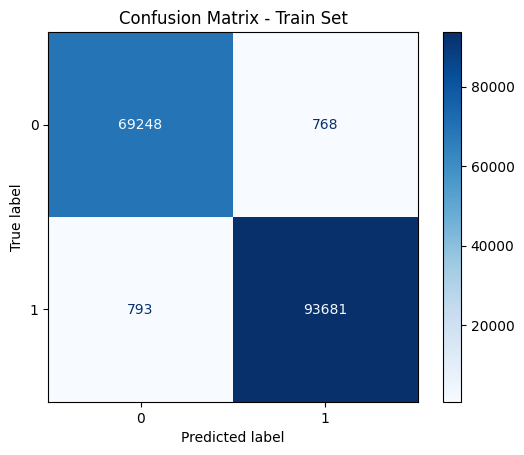

In [127]:

# Ma trận nhầm lẫn
cm = confusion_matrix(y_train, y_pred_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)

# Vẽ
plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix - Train Set")
plt.show()

In [124]:
# Đánh giá trên tập validation
y_pred_val = best_model.predict(X_val)
print("\nBáo cáo phân loại trên tập validation:")
print(classification_report(y_val, y_pred_val))


Báo cáo phân loại trên tập validation:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     10055
           1       0.99      0.99      0.99     13420

    accuracy                           0.99     23475
   macro avg       0.99      0.99      0.99     23475
weighted avg       0.99      0.99      0.99     23475



<Figure size 600x600 with 0 Axes>

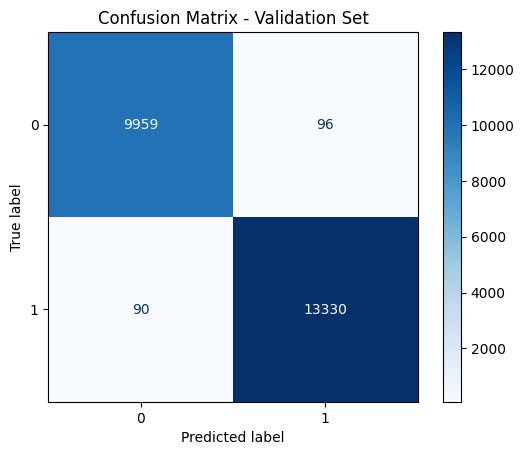

In [128]:
cm = confusion_matrix(y_val, y_pred_val)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)

plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix - Validation Set")
plt.show()

In [125]:
# Đánh giá trên tập test
y_pred_test = best_model.predict(X_test)
print("\nBáo cáo phân loại trên tập test:")
print(classification_report(y_test, y_pred_test))


Báo cáo phân loại trên tập test:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     20066
           1       0.99      0.99      0.99     26956

    accuracy                           0.99     47022
   macro avg       0.99      0.99      0.99     47022
weighted avg       0.99      0.99      0.99     47022



<Figure size 600x600 with 0 Axes>

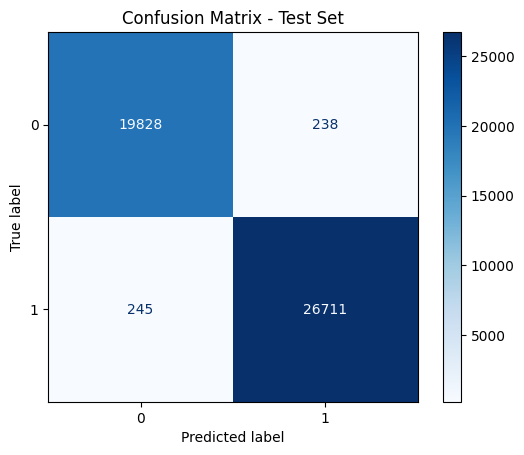

In [130]:
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)

plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix - Test Set")
plt.show()

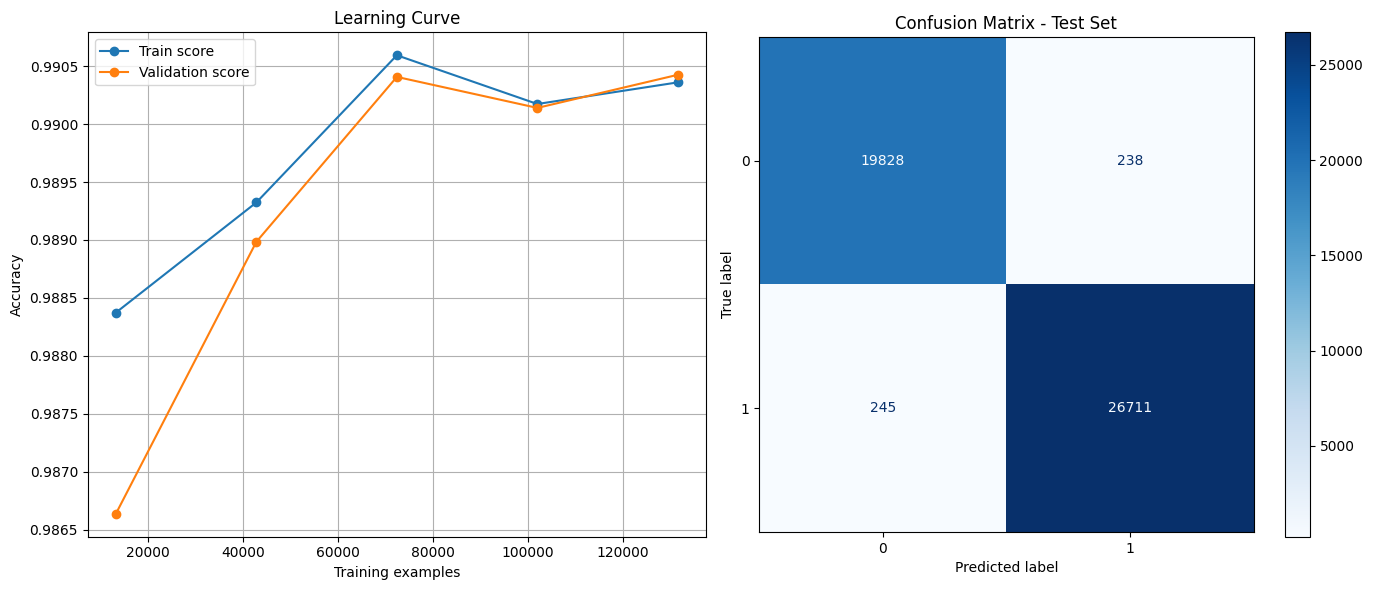

In [135]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

# === Confusion Matrix ===
y_pred_test = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_test)

# === Learning Curve ===
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train, y_train, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1
)

train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

# === Vẽ subplot: 1 dòng 2 cột ===
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- Subplot 1: Learning Curve ---
axes[0].plot(train_sizes, train_scores_mean, 'o-', label='Train score')
axes[0].plot(train_sizes, test_scores_mean, 'o-', label='Validation score')
axes[0].set_xlabel('Training examples')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Learning Curve')
axes[0].legend()
axes[0].grid(True)

# --- Subplot 2: Confusion Matrix ---
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(ax=axes[1], cmap=plt.cm.Blues, values_format='d')
axes[1].set_title("Confusion Matrix - Test Set")

plt.tight_layout()
plt.show()


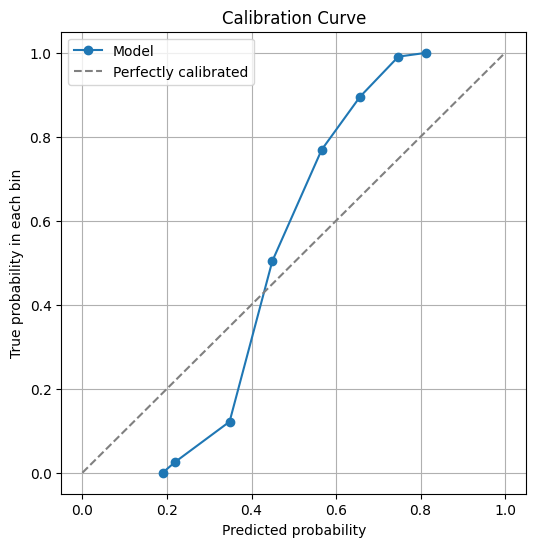

In [136]:
plt.figure(figsize=(6, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Model')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')
plt.xlabel('Predicted probability')
plt.ylabel('True probability in each bin')
plt.title('Calibration Curve')
plt.legend()
plt.grid(True)
plt.show()


In [138]:
pip install shap

/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


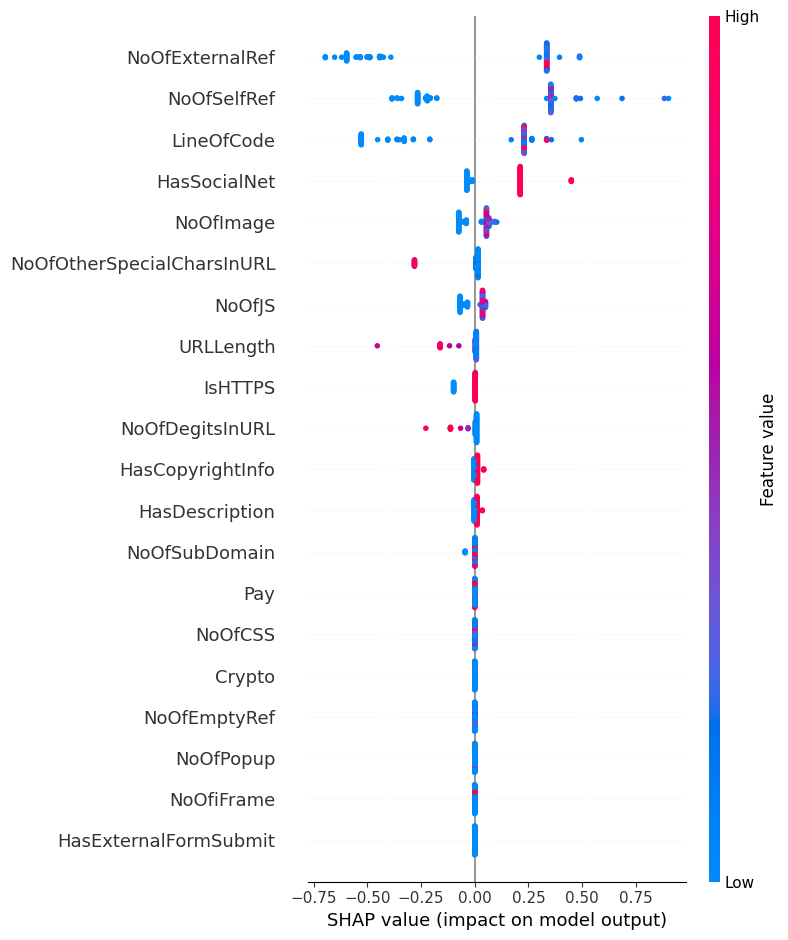

In [140]:
import shap

# Lấy 100 mẫu đầu tiên để hiển thị (tránh quá tải nếu dữ liệu lớn)
X_sample = X_test[:100]

# Tạo SHAP explainer (với tree-based model như XGBoost, RandomForest)
explainer = shap.TreeExplainer(best_model)

# Tính giá trị SHAP
shap_values = explainer.shap_values(X_sample)
shap.summary_plot(shap_values, X_sample)

# CatBoost

In [141]:
import pandas as pd

# Ví dụ: nếu bạn upload thẳng file vào MyDrive
path = '/content/drive/MyDrive/PhiUSIIL_Phishing_URL_Dataset.csv'

df = pd.read_csv(path)
df.head()

,FILENAME,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
0,521848.txt,https://www.southbankmosaics.com,31,www.southbankmosaics.com,24,0,com,100.0,1.000000,0.522907,...,0,0,1,34,20,28,119,0,124,1
1,31372.txt,https://www.uni-mainz.de,23,www.uni-mainz.de,16,0,de,100.0,0.666667,0.032650,...,0,0,1,50,9,8,39,0,217,1
2,597387.txt,https://www.voicefmradio.co.uk,29,www.voicefmradio.co.uk,22,0,uk,100.0,0.866667,0.028555,...,0,0,1,10,2,7,42,2,5,1
3,554095.txt,https://www.sfnmjournal.com,26,www.sfnmjournal.com,19,0,com,100.0,1.000000,0.522907,...,1,1,1,3,27,15,22,1,31,1
4,151578.txt,https://www.rewildingargentina.org,33,www.rewildingargentina.org,26,0,org,100.0,1.000000,0.079963,...,1,0,1,244,15,34,72,1,85,1


In [142]:
# Kiểm tra trùng lặp
duplicates = X.duplicated(keep=False).sum()
print(f"Số mẫu trùng lặp trong dataset: {duplicates}")
X = X.drop_duplicates()
y = y.loc[X.index]

Số mẫu trùng lặp trong dataset: 0


In [143]:
# Kiểm tra giá trị thiếu
print("\nSố giá trị thiếu trong mỗi cột:\n", X.isna().sum())



Số giá trị thiếu trong mỗi cột:
 URLLength                     0
DomainLength                  0
IsDomainIP                    0
URLSimilarityIndex            0
CharContinuationRate          0
TLDLegitimateProb             0
URLCharProb                   0
TLDLength                     0
NoOfSubDomain                 0
HasObfuscation                0
NoOfObfuscatedChar            0
ObfuscationRatio              0
NoOfLettersInURL              0
LetterRatioInURL              0
NoOfDegitsInURL               0
DegitRatioInURL               0
NoOfEqualsInURL               0
NoOfQMarkInURL                0
NoOfAmpersandInURL            0
NoOfOtherSpecialCharsInURL    0
SpacialCharRatioInURL         0
IsHTTPS                       0
LineOfCode                    0
LargestLineLength             0
HasTitle                      0
DomainTitleMatchScore         0
URLTitleMatchScore            0
HasFavicon                    0
Robots                        0
IsResponsive                  0
NoOfUR

In [144]:
# Xử lý giá trị thiếu
object_cols = X.select_dtypes(include=['object']).columns
for col in object_cols:
    X[col] = X[col].fillna(X[col].mode()[0])
X = X.fillna(X.select_dtypes(include=['float', 'int']).median())

In [145]:
# Kiểm tra cardinality
for col in object_cols:
    print(f"Cột {col}: {X[col].nunique()} giá trị duy nhất")


In [146]:
# Loại bỏ cột high cardinality
high_cardinality_cols = ['FILENAME', 'URL', 'Domain', 'TLD', 'Title']
X = X.drop(columns=high_cardinality_cols, errors='ignore')

In [147]:
# Xử lý cột boolean (chuyển thành 0/1 trực tiếp)
boolean_cols = ['IsDomainIP', 'HasObfuscation', 'IsHTTPS', 'HasTitle', 'HasFavicon',
                'Robots', 'IsResponsive', 'HasDescription', 'HasExternalFormSubmit',
                'HasSocialNet', 'HasSubmitButton', 'HasHiddenFields', 'HasPasswordField',
                'Bank', 'Pay', 'Crypto', 'HasCopyrightInfo']
for col in boolean_cols:
    if col in X.columns:
        X[col] = X[col].astype(int)  # Giả sử dữ liệu đã là 0/1 hoặc True/False

In [148]:
# Chia dữ liệu thành train/val/test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.667, random_state=42)
print(f"Kích thước tập train: {X_train.shape}")
print(f"Kích thước tập validation: {X_val.shape}")
print(f"Kích thước tập test: {X_test.shape}")

Kích thước tập train: (164490, 50)
Kích thước tập validation: (23475, 50)
Kích thước tập test: (47022, 50)


In [149]:
# Kiểm tra tương quan với nhãn
correlations = X_train.corrwith(y_train)
print("\nTương quan với nhãn:\n", correlations.sort_values(ascending=False))



Tương quan với nhãn:
 URLSimilarityIndex            0.859887
HasSocialNet                  0.782911
HasCopyrightInfo              0.741617
HasDescription                0.689637
IsHTTPS                       0.613600
DomainTitleMatchScore         0.584531
HasSubmitButton               0.577396
IsResponsive                  0.551958
URLTitleMatchScore            0.538933
HasHiddenFields               0.507812
HasFavicon                    0.492276
NoOfJS                        0.471938
URLCharProb                   0.468711
CharContinuationRate          0.466861
HasTitle                      0.461802
Robots                        0.392389
Pay                           0.359445
NoOfSelfRef                   0.336364
LineOfCode                    0.296096
NoOfImage                     0.274346
NoOfExternalRef               0.262127
NoOfiFrame                    0.210800
Bank                          0.188453
HasExternalFormSubmit         0.167281
HasPasswordField              0.139138
No

In [150]:
# Loại bỏ đặc trưng có tương quan cao (>0.8 để chặt chẽ hơn)
suspicious_features = correlations[abs(correlations) > 0.8].index.tolist()
if suspicious_features:
    print(f"Loại bỏ các đặc trưng nghi ngờ: {suspicious_features}")
    X_train = X_train.drop(columns=suspicious_features)
    X_val = X_val.drop(columns=suspicious_features)
    X_test = X_test.drop(columns=suspicious_features)

Loại bỏ các đặc trưng nghi ngờ: ['URLSimilarityIndex']


In [152]:
# Xem mẫu dữ liệu để kiểm tra label leakage
print("\nMẫu dữ liệu (10 mẫu đầu):\n", X.head(10))
print("\nNhãn tương ứng:\n", y.head(10))


Mẫu dữ liệu (10 mẫu đầu):
    URLLength  DomainLength  IsDomainIP  URLSimilarityIndex  \
0         31            24           0               100.0   
1         23            16           0               100.0   
2         29            22           0               100.0   
3         26            19           0               100.0   
4         33            26           0               100.0   
5         30            23           0               100.0   
6         25            18           0               100.0   
7         25            18           0               100.0   
8         29            22           0               100.0   
9         18            11           0               100.0   

   CharContinuationRate  TLDLegitimateProb  URLCharProb  TLDLength  \
0              1.000000           0.522907     0.061933          3   
1              0.666667           0.032650     0.050207          2   
2              0.866667           0.028555     0.064129          2   
3        

In [151]:
# Tính trọng số lớp
class_weights = len(y) / (2 * y.value_counts())
weight_dict = {0: class_weights[0], 1: class_weights[1]}

In [153]:
# Tinh chỉnh mô hình CatBoost
model = CatBoostClassifier(
    random_state=42,
    scale_pos_weight=weight_dict[1]/weight_dict[0],  # Xử lý mất cân bằng
    reg_lambda=6.0,  # L2 regularization
    max_depth=2,    # Độ sâu tối đa
    iterations=20,  # Tương ứng với n_estimators
    learning_rate=0.1,  # Tốc độ học
    subsample=0.6,  # Tỷ lệ mẫu
    colsample_bylevel=0.6,  # Tỷ lệ đặc trưng (tương tự colsample_bytree)
    min_data_in_leaf=15,  # Tương ứng với min_child_weight/min_child_samples
    verbose=0  # Tắt log chi tiết
)
param_grid = {
    'iterations': [20],
    'max_depth': [2],
    'learning_rate': [0.01, 0.05],
    'min_data_in_leaf': [15, 20]  # Tương ứng với min_child_samples
}
grid_search = GridSearchCV(model, param_grid, cv=10, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)


GridSearchCV(cv=10,
             estimator=<catboost.core.CatBoostClassifier object at 0x797f31d6a350>,
             n_jobs=-1,
             param_grid={'iterations': [20], 'learning_rate': [0.01, 0.05],
                         'max_depth': [2], 'min_data_in_leaf': [15, 20]},
             scoring='f1')

In [154]:
# Lấy mô hình tốt nhất
best_model = grid_search.best_estimator_
print("Tham số tốt nhất:", grid_search.best_params_)
print("Điểm F1 trung bình trên 10-fold CV:", grid_search.best_score_)


Tham số tốt nhất: {'iterations': 20, 'learning_rate': 0.05, 'max_depth': 2, 'min_data_in_leaf': 15}
Điểm F1 trung bình trên 10-fold CV: 0.9939107787948611


In [155]:
# Tìm ngưỡng tối ưu
y_val_pred_proba = best_model.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_val_pred_proba)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Ngưỡng tối ưu: {optimal_threshold}")

Ngưỡng tối ưu: 0.42901962572581


In [156]:
# Kiểm tra tầm quan trọng đặc trưng
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)
print("\nTầm quan trọng đặc trưng:\n", feature_importance.head(10))


Tầm quan trọng đặc trưng:
                        feature  importance
21                  LineOfCode   33.870020
18  NoOfOtherSpecialCharsInURL   15.825945
43                   NoOfImage   11.808546
46                 NoOfSelfRef   10.938791
48             NoOfExternalRef    9.833858
0                    URLLength    5.294590
35                HasSocialNet    4.220210
13             NoOfDegitsInURL    2.507601
14             DegitRatioInURL    1.844850
45                      NoOfJS    1.638634


In [157]:
# Đánh giá trên tập train
y_pred_train = best_model.predict(X_train)
print("\nBáo cáo phân loại trên tập train:")
print(classification_report(y_train, y_pred_train))



Báo cáo phân loại trên tập train:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     70016
           1       1.00      0.99      0.99     94474

    accuracy                           0.99    164490
   macro avg       0.99      0.99      0.99    164490
weighted avg       0.99      0.99      0.99    164490



<Figure size 600x600 with 0 Axes>

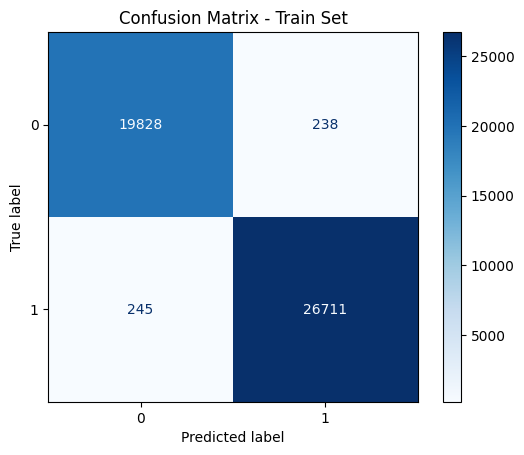

In [161]:
# Vẽ biểu đồ
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)

plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix - Train Set")
plt.grid(False)
plt.show()


In [158]:
# Đánh giá trên tập validation
y_pred_val = best_model.predict(X_val)
print("\nBáo cáo phân loại trên tập validation:")
print(classification_report(y_val, y_pred_val))


Báo cáo phân loại trên tập validation:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     10055
           1       1.00      0.99      0.99     13420

    accuracy                           0.99     23475
   macro avg       0.99      0.99      0.99     23475
weighted avg       0.99      0.99      0.99     23475



<Figure size 600x600 with 0 Axes>

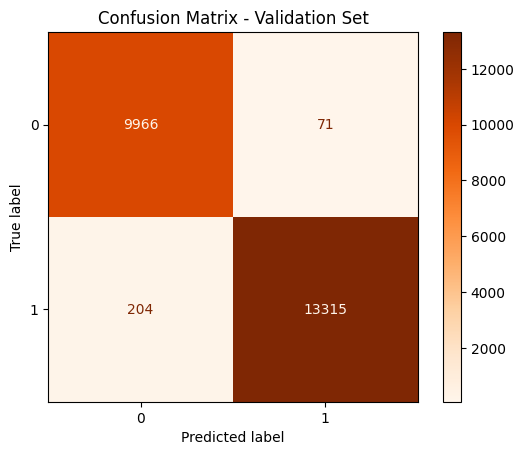

In [162]:
# Vẽ biểu đồ confusion matrix
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=best_model.classes_)

plt.figure(figsize=(6, 6))
disp_val.plot(cmap=plt.cm.Oranges, values_format='d')
plt.title("Confusion Matrix - Validation Set")
plt.grid(False)
plt.show()

In [159]:
# Đánh giá trên tập test
y_pred_test = best_model.predict(X_test)
print("\nBáo cáo phân loại trên tập test:")
print(classification_report(y_test, y_pred_test))



Báo cáo phân loại trên tập test:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     20066
           1       0.99      0.99      0.99     26956

    accuracy                           0.99     47022
   macro avg       0.99      0.99      0.99     47022
weighted avg       0.99      0.99      0.99     47022



<Figure size 600x600 with 0 Axes>

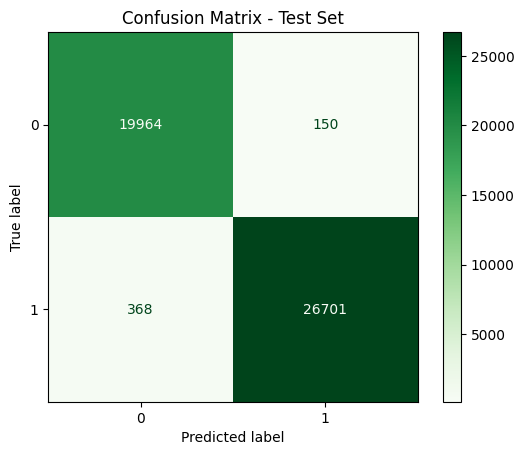

In [163]:
# Vẽ biểu đồ
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=best_model.classes_)

plt.figure(figsize=(6, 6))
disp_test.plot(cmap=plt.cm.Greens, values_format='d')
plt.title("Confusion Matrix - Test Set")
plt.grid(False)
plt.show()

In [164]:
# Tính learning curve
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train, y_train,
    cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1
)

# Tính trung bình và độ lệch chuẩn
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

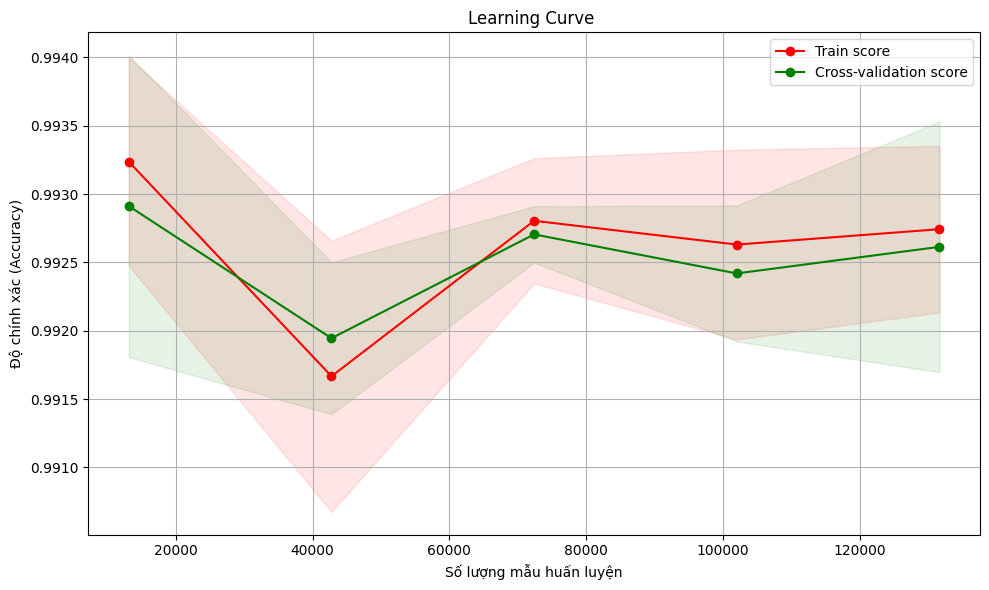

In [167]:
# Vẽ biểu đồ learning curve
plt.figure(figsize=(10, 6))
plt.title("Learning Curve ")
plt.xlabel("Số lượng mẫu huấn luyện")
plt.ylabel("Độ chính xác (Accuracy)")

# Train
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Train score")
plt.fill_between(train_sizes,
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std,
                 alpha=0.1, color="r")

# Validation
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.fill_between(train_sizes,
                 test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std,
                 alpha=0.1, color="g")

plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()

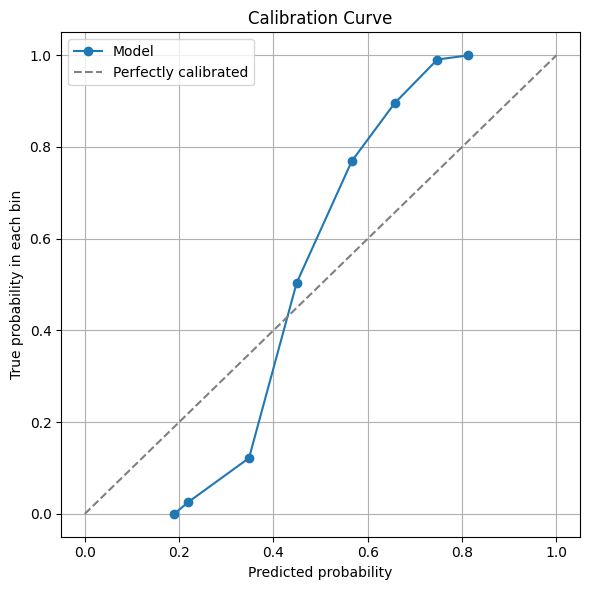

In [166]:
plt.figure(figsize=(6, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Model')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated', color='gray')
plt.xlabel('Predicted probability')
plt.ylabel('True probability in each bin')
plt.title('Calibration Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

 92%|==================  | 43489/47022 [00:17<00:01]       

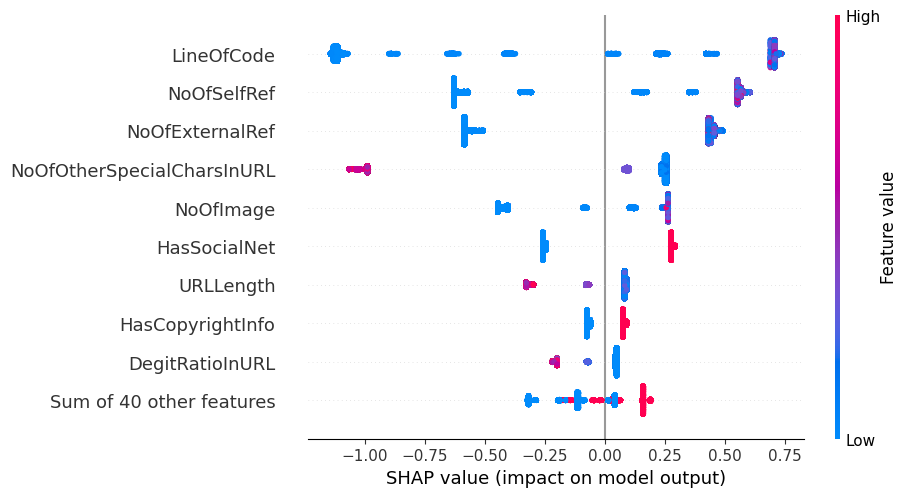

In [168]:
import shap

# Nếu dùng XGBoost, LightGBM, hoặc RandomForest
explainer = shap.Explainer(best_model, X_test)
shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values)